In [1]:
import IPython.core.display
import pydna
import pydna.primer
import pydna.dseqrecord
import pydna.amplify
import pydna.assembly
import pydna.gel
import pydna.ladders
from pydna.dseqrecord import Dseqrecord
import pandas as pd

# 03_1_Incorporation of SPs into A. oryzae

In this notebook we will have to do the folowing: 

1. Amplify repair templates that have the incorporated signal peptides
- Simulate amplification 
- Amplify
- Verify by gen-electrophorese
2. Transform A. oryzae with pre-made CRISPR plasmid
- Send for sequencing
- Verification of sequences. 





# 1 Amplify repair templates

In [2]:
# Load the latest form of the singalP dataset
df_signalP = pd.read_csv('/Users/lucaslevassor/projects/Signal_peptide_project/data/03_proteomics_data/signalP_common_peptides_wo_NaN.csv')
df_signalP['length'] = df_signalP['Peptide sequences'].apply(len)

# Filter the acccessions which are 22 bp or shorter and isolate the top 25 values
df_signalP_filtered = df_signalP[df_signalP["length"] <= 22]
top25_signalP = df_signalP_filtered.head(25).reset_index(drop=True)
top25_acc_numbers = top25_signalP['Accession'].to_list()

In [3]:
from teemi.design.fetch_sequences import read_fasta_files

In [4]:
# the primers
pTef_primers = read_fasta_files('/Users/lucaslevassor/projects/Signal_peptide_project/data/09_primers/pTef_primers_1.fasta')
RFP_primers = read_fasta_files('/Users/lucaslevassor/projects/Signal_peptide_project/data/09_primers/RFP_primers_1.fasta')

pTef_primers

[SeqRecord(seq=Seq('ggccgtacagaaatagagACCACCACGCGACCATCATGGTGAAGGTTGTGTTAT...TGG'), id='pTef_r_AO090003001591', name='pTef_r_AO090003001591', description='pTef_r_AO090003001591 description', dbxrefs=[]),
 SeqRecord(seq=Seq('ggcaggccatgaagatagCAGAGACACGAAGCATGGTGAAGGTTGTGTTATGTTTTGTGG'), id='pTef_r_AO090103000076', name='pTef_r_AO090103000076', description='pTef_r_AO090103000076 description', dbxrefs=[]),
 SeqRecord(seq=Seq('ggccgtacagaaatagagACCACCACGCGACCATCATGGTGAAGGTTGTGTTAT...TGG'), id='pTef_r_AO090023000944', name='pTef_r_AO090023000944', description='pTef_r_AO090023000944 description', dbxrefs=[]),
 SeqRecord(seq=Seq('aggcgagagtgacaagagTAGGGAGGTGCATGGTGAAGGTTGTGTTATGTTTTGTGG'), id='pTef_r_AO090701000295', name='pTef_r_AO090701000295', description='pTef_r_AO090701000295 description', dbxrefs=[]),
 SeqRecord(seq=Seq('gggcagtagaaatagcagCAGAGATCTTCATGGTGAAGGTTGTGTTATGTTTTGTGG'), id='pTef_r_AO090012000708', name='pTef_r_AO090012000708', description='pTef_r_AO090012000708 description',

In [5]:
# THe templates 
from Bio import SeqIO
RFP = Dseqrecord(SeqIO.read("/Users/lucaslevassor/projects/Signal_peptide_project/data/10_genetic_parts/parts/RFP.fasta", "fasta"))
pTef = Dseqrecord(SeqIO.read("/Users/lucaslevassor/projects/Signal_peptide_project/data/10_genetic_parts/parts/pTEF.fasta", "fasta"))

Since all the primers have the same annealing part they should all use the same PCR program. We can make a PCR program in the following way. 

In [6]:
from teemi.build.PCR import calculate_volumes, Q5_NEB_PCR_program, calculate_processing_speed

### Thermocycler program

In [7]:
from pydna.amplify import pcr
RFP_amplicon = pcr(RFP_primers[-1], RFP_primers[0][-15:], RFP)
RFP_amplicon

Amplicon(692)

In [8]:
RFP_amplicon.annotations['polymerase'] = 'Q5 Hot Start'

calculate_processing_speed(RFP_amplicon)
Q5_NEB_PCR_program(RFP_amplicon)

|98°C|98°C               |    |tmf:64.0
|____|_____          72°C|72°C|tmr:57.0
|30 s|10s  \ 58.0°C _____|____|30s/kb
|    |      \______/ 0:21|2min|GC 63.6%
|    |       20s         |    |692bp


In [9]:
pTef_amplicon = pcr(pTef_primers[0][-26:], pTef_primers[-1], pTef)
pTef_amplicon

Amplicon(886)

In [10]:
pTef_amplicon.annotations['polymerase'] = 'Q5 Hot Start'

calculate_processing_speed(pTef_amplicon)
Q5_NEB_PCR_program(pTef_amplicon)

|98°C|98°C               |    |tmf:66.0
|____|_____          72°C|72°C|tmr:66.0
|30 s|10s  \ 67.0°C _____|____|30s/kb
|    |      \______/ 0:27|2min|GC 50.7%
|    |       20s         |    |886bp


In [11]:
from teemi.build.PCR import primer_ta_neb
pTEF_ta = primer_ta_neb(str(pTef_primers[0][-26:].seq), str(pTef_primers[-1].seq), conc=0.4, prodcode='phusion-0')
RFP_ta = primer_ta_neb(str(RFP_primers[-1].seq), str(RFP_primers[0][-15:].seq), conc=0.4, prodcode='phusion-0')

print(f'pTEF anealing temperature with phusion-polymerase is calculated to be {pTEF_ta}')
print(f'RFP anealing temperature with phusion-polymerase is calculated to be {RFP_ta}')

pTEF anealing temperature with phusion-polymerase is calculated to be 63
RFP anealing temperature with phusion-polymerase is calculated to be 57


### PCR reaction mix

In [12]:
calculate_volumes(vol_p_reac = 20, 
        no_of_reactions = len(RFP_primers)+1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])


,vol_p_reac,vol_p_27_reac
Template,0.4,10.8
Primer 1,1.0,27.0
Primer 2,1.0,27.0
H20,7.6,205.2
Pol,10.0,270.0
Total,20.0,540.0


## Simulation of gel 

In [13]:
from pydna.gel import gel
from pydna.ladders import *

In [14]:
from pydna.amplify import pcr
from pydna.primer import Primer

pTef_amplicons = []
for i in range(len(pTef_primers)-1): 
    amplicon = pcr(pTef_primers[i], pTef_primers[-1], pTef)
    pTef_amplicons.append(amplicon)


RFP_amplicons = []
for i in range(len(RFP_primers)-1): 
    amplicon = pcr(RFP_primers[-1], RFP_primers[i], RFP)
    RFP_amplicons.append(amplicon)

In [15]:
# changing the names of the amplicons
for i in range(len(pTef_amplicons)):
    pTef_amplicons[i].name =  f'pTef_{pTef_amplicons[i].name }_{top25_acc_numbers[i]}'
    
for i in range(len(RFP_amplicons)):
    RFP_amplicons[i].name =  f'RFP_{RFP_amplicons[i].name }_{top25_acc_numbers[i]}'

In [16]:
pTEf_list_of_list = [[amplicon] for amplicon in pTef_amplicons]

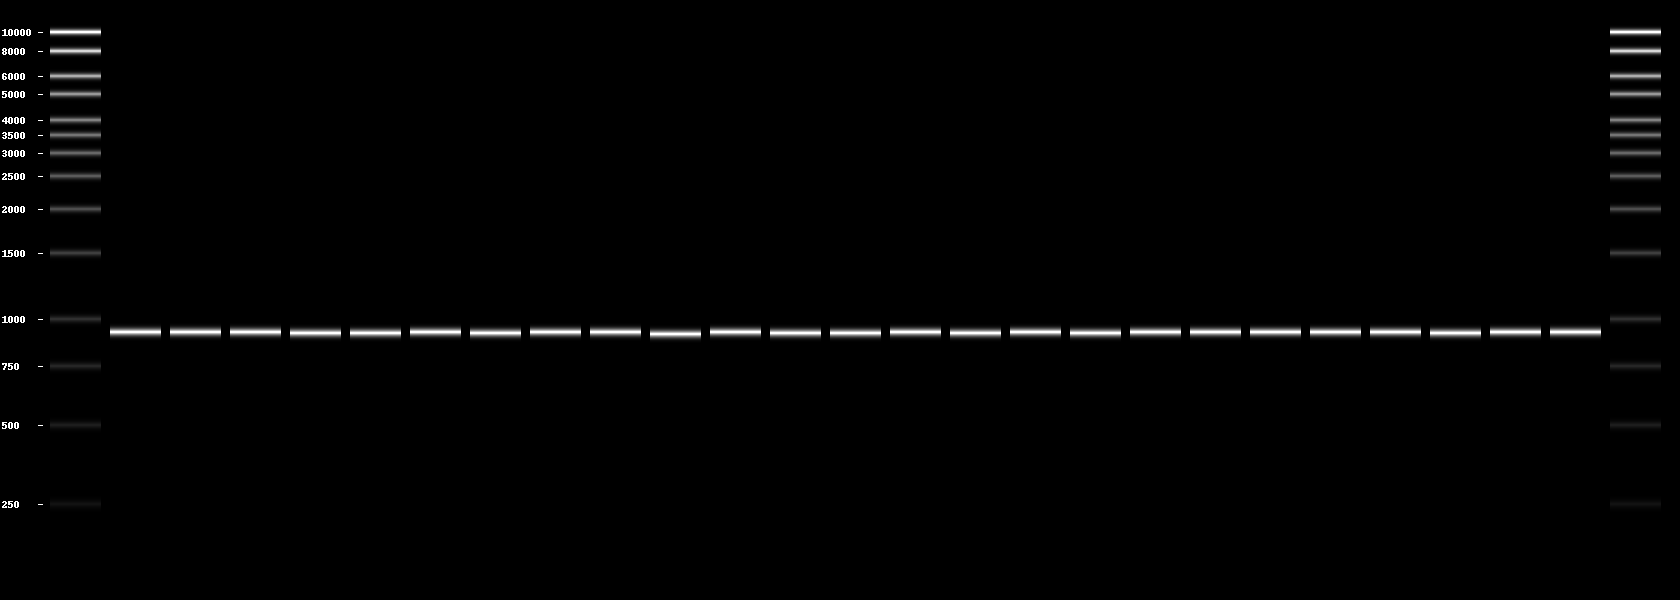

In [17]:
gel([GeneRuler_1kb,*[[band] for band in pTef_amplicons], GeneRuler_1kb])

Insert gel picture here: 

In [18]:
path = ''
#IPython.core.display.Image(path, width=600)

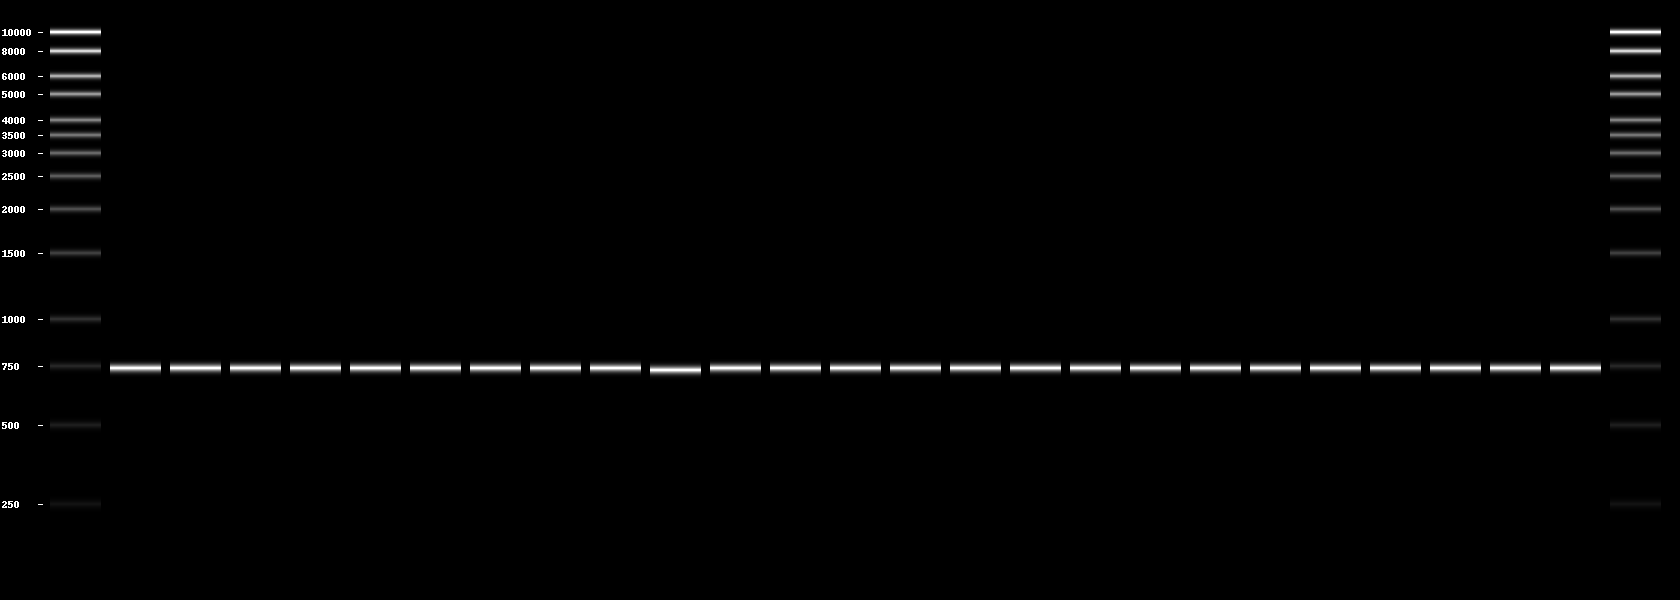

In [19]:
gel([GeneRuler_1kb,*[[band] for band in RFP_amplicons], GeneRuler_1kb])

Insert gel picture here: 



In [20]:
path = ''
#IPython.core.display.Image(path, width=600)

In [21]:
path = ''
#IPython.core.display.Image(path, width=600)

## Gel purification 

Follow the gel-purification kits instructions to purify the bands 

Add the concentrations below

In [22]:
from teemi.lims.csv_database import add_annotations, get_unique_id, add_sequences_to_dataframe

In [23]:
pTef_concentrations = [123,86,47,68,89,98,79,87,68,56,88,22,55,66,77,142,132,139,122,200,120,67,89,78,99]
RFP_concentrations = [123,86,47,68,89,98,79,87,68,56,88,22,55,66,77,142,132,139,122,200,120,67,89,78,99]

In [24]:
pTef_amplicons_conc = [add_annotations([pTef_amplicons[i]], volume = 50, concentration = pTef_concentrations[i],  location = f'l4_I0{i}',  comments = 'pTef repair')[0] for i in range(len(pTef_concentrations))]

In [25]:
RFP_amplicons_conc = [add_annotations([RFP_amplicons[i]], volume = 50, concentration = RFP_concentrations[i],  location = f'l5_I0{i}',  comments = 'RFP repair')[0] for i in range(len(pTef_concentrations))]

In [26]:
# We can use a previously generated CRISPR plasmid
crispr_plasmid = SeqIO.read('/Users/lucaslevassor/projects/Signal_peptide_project/data/10_genetic_parts/plasmids/trp_plasmid.gb', 'genbank')
crispr_plasmid.name = 'crispr_plasmid'
crispr_plasmid.annotations['batches'] = [{'location':'temp_fridge_bocx', 'concentration':210, 'volume':66}]

# Positive control plasmid
positive_plasmid = SeqIO.read('/Users/lucaslevassor/projects/Signal_peptide_project/data/10_genetic_parts/plasmids/ura_plasmid.gb', 'genbank')
positive_plasmid.name = 'ura_plasmid'
positive_plasmid.id = 'ura_plasmid'

# add concentration and volume
positive_plasmid.annotations['batches'] = [{'location':'temp_fridge_bocx', 'concentration':98, 'volume':150}]

In [27]:
reaction_participants = []

for i in range(len(pTef_amplicons_conc)):
    reaction_participants.append([crispr_plasmid, pTef_amplicons_conc[i], RFP_amplicons_conc[i]])
    
reaction_participants.append([crispr_plasmid]) # n.ctr
# reaction_participants.append([pTef_amplicon_test]) # n.ctr
# reaction_participants.append([RFP_amplicon_test]) # n.ctr
reaction_participants.append([positive_plasmid]) # n.ctr


In [29]:
#Construct dict with reaction name as keys and wanted amounts as values
pool_amplicons =   pTef_amplicons_conc + RFP_amplicons_conc + [crispr_plasmid] + [positive_plasmid]
pool_amplicon_names = [amp.name for amp in pool_amplicons]
part_amounts_per_reaction = dict(zip(pool_amplicon_names,[0.0005]*len(pool_amplicon_names)))


# plasmid participants are typically given in ng....
nmol_gRNA = 0.00014
nmol_pctr_URA = 0.0005

# in nmol
wanted_amounts = {'crispr_plasmid'  : nmol_gRNA,
                'ura_plasmid'       : nmol_pctr_URA,
                **part_amounts_per_reaction}

# media
media = ['SC-UT'] * len(reaction_participants)


# Add reaction names
reaction_names = top25_acc_numbers + ['n.ctr','p.ctr']

# lets make the table
from teemi.build.transformation import ng_to_nmol, transformation_mix
transformation_table = transformation_mix(reaction_names, reaction_participants, wanted_amounts = wanted_amounts, water_dna_p_reac = 50, media = media)
transformation_table

,name,crispr_plasmid,pTef_923bp_PCR_prod_AO090003001591,RFP_740bp_PCR_prod_AO090003001591,pTef_920bp_PCR_prod_AO090103000076,RFP_737bp_PCR_prod_AO090103000076,pTef_923bp_PCR_prod_AO090023000944,RFP_740bp_PCR_prod_AO090023000944,pTef_917bp_PCR_prod_AO090701000295,RFP_737bp_PCR_prod_AO090701000295,...,RFP_740bp_PCR_prod_AO090001000733,pTef_917bp_PCR_prod_AO090103000216,RFP_737bp_PCR_prod_AO090103000216,pTef_923bp_PCR_prod_AO090038000258,RFP_740bp_PCR_prod_AO090038000258,pTef_923bp_PCR_prod_AO090026000516,RFP_740bp_PCR_prod_AO090026000516,ura_plasmid,water,plate on
0,AO090003001591,13.6,2.4,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,SC-UT
1,AO090103000076,13.6,NaN,NaN,3.5,2.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.1,SC-UT
2,AO090023000944,13.6,NaN,NaN,NaN,NaN,6.4,5.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.9,SC-UT
3,AO090701000295,13.6,NaN,NaN,NaN,NaN,NaN,NaN,4.4,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.5,SC-UT
4,AO090012000708,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.4,SC-UT
5,AO090005001090,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.9,SC-UT
6,AO090023000905,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.6,SC-UT
7,AO090038000279,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.2,SC-UT
8,AO090005000409,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.5,SC-UT
9,AO090003000354,13.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.9,SC-UT


### Calculate reagents for all reactions

In [30]:
transformation_table.sum(numeric_only = True)

crispr_plasmid                        353.6
pTef_923bp_PCR_prod_AO090003001591      2.4
RFP_740bp_PCR_prod_AO090003001591       2.0
pTef_920bp_PCR_prod_AO090103000076      3.5
RFP_737bp_PCR_prod_AO090103000076       2.8
pTef_923bp_PCR_prod_AO090023000944      6.4
RFP_740bp_PCR_prod_AO090023000944       5.1
pTef_917bp_PCR_prod_AO090701000295      4.4
RFP_737bp_PCR_prod_AO090701000295       3.5
pTef_917bp_PCR_prod_AO090012000708      3.3
RFP_737bp_PCR_prod_AO090012000708       2.7
pTef_920bp_PCR_prod_AO090005001090      3.1
RFP_737bp_PCR_prod_AO090005001090       2.4
pTef_917bp_PCR_prod_AO090023000905      3.8
RFP_737bp_PCR_prod_AO090023000905       3.0
pTef_920bp_PCR_prod_AO090038000279      3.4
RFP_737bp_PCR_prod_AO090038000279       2.8
pTef_920bp_PCR_prod_AO090005000409      4.4
RFP_737bp_PCR_prod_AO090005000409       3.5
pTef_914bp_PCR_prod_AO090003000354      5.3
RFP_731bp_PCR_prod_AO090003000354       4.2
pTef_920bp_PCR_prod_AO090003001036      3.4
RFP_740bp_PCR_prod_AO09000300103